In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [5]:
from cols_list import cols_enem
from input_enem import categorical_labels, cols_names
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 60)

### Funções

In [21]:
def sk_kurt(df):
    for col in df.columns:
        skew = df[col].skew()
        kurt = df[col].kurt()
        
        if skew > 0:
            assimetria = 'Positiva'
        elif skew < 0:
            assimetria = 'Negativa'
        

        print(f'Skewness - {col}: {skew} - Assimetria: {assimetria}')
        print(f'Kurtosis - {col}: {kurt}')

In [22]:
def load_year_enem(year, cols):
    enem = pd.read_csv(
        f'../../Dados/Enem/microdados_enem_{year}/DADOS/MICRODADOS_ENEM_{year}.csv',
        usecols = cols,
        sep = ';',
        header = 0,
        #nrows=300*1000,
        encoding='latin-1',
        dtype={'NO_MUNICIPIO_ESC': 'object',
           'SG_UF_ESC': 'object',
           'CO_MUNICIPIO_ESC': 'object'}
    )
    return enem

In [23]:
def filter_enem(df):
    pre_filter = len(df)
    print('Tamanho do dataset pré-filtragem: ', pre_filter)

    # Aplicando filtragem dos dados
    df = df[df['IN_TREINEIRO']==0] # Não é treineiro
    df = df[df['TP_ENSINO']==1] # Ensino Regular
    df = df[df['TP_ST_CONCLUSAO']!=4] # Está cursando ensino médio ou já cursou
    df = df[df['TP_ANO_CONCLUIU']<=1] # Está cursando ou concluiu o ensino médio até 2018
    df = df[df['TP_NACIONALIDADE']==1] # Brasileiro

    # Removendo colunas pós filtragem
    df = df.drop(columns=['TP_ENSINO','IN_TREINEIRO','TP_ANO_CONCLUIU','TP_NACIONALIDADE','TP_ST_CONCLUSAO']) 

    post_filter = len(df)
    print('Tamanho do dataset pós-filtragem: ', post_filter)
    print('Taxa de filtragem: ', (pre_filter-post_filter)/pre_filter)
    return df

In [24]:
def show_proportion(df, col):

    df[col].replace(categorical_labels[col]).value_counts(normalize=True).plot(kind='bar')
    plt.xticks(rotation=90)
    try:
        plt.title(f'{cols_names[col]}')
    except:
        plt.title(f'{col}')

In [25]:
def evolution(df, var):
    df = df[[col for col in df.columns if col.startswith(var) or "NU_ANO" in col]]
    df = df.melt(id_vars=['NU_ANO'], value_vars=[col for col in df.columns if 'NU_ANO' not in col], value_name='QTD', var_name=var)
    df[var] = df[var].str.split('_').str[-1]
    return df
    

In [26]:
def show_evolution(df, var):
    view = evolution(df, var)
    view[var] = view[var].replace(categorical_labels[var])
    for values in view[var].unique():
        plt.plot(view[view[var]==values]['NU_ANO'], view[view[var]==values]['QTD'], label=values)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=False, ncol=4) #lower left
    plt.xticks(rotation=90)
    try:
        plt.title(f'{cols_names[var]}')
    except:
        plt.title(f'{var}')


In [ ]:
def compare(df, filter):
    df = df[df.iloc[:,1] == filter]
    df = df[df['NU_ANO'].isin(['2019', '2021'])]
    print('Variação em pontos perceituais para o filtro: {}'.format(filter))
    reduc = (df[df['NU_ANO']=='2019'].iloc[0,3]) - (df[df['NU_ANO']=='2021'].iloc[0,3])
    print('Redução de {} p.p.'.format(reduc * 100))
    return df

In [19]:
def cross_evolution(df1, df2, col):
    return evolution(df1, col).merge(evolution(df2, col), on=['NU_ANO',col], suffixes=['_abs','_norm'])

Carregando Dataset

In [111]:
enem19 = filter_enem(load_year_enem(2019, cols_enem))

Tamanho do dataset pré-filtragem:  5095171
Tamanho do dataset pós-filtragem:  1604459
Taxa de filtragem:  0.6851020309230054


# Análise Desagregada

### Estatística Univariada
- Verificando distribuição das variáveis de interesse

#### Cross Sectional - Distribuição no ano

In [13]:
enem19.head()

,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q012,Q019,Q022,Q024,Q025
8,2019,5,F,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,C,C,F,6,C,A,B,C,A,B,B,B,A,A
9,2019,2,M,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,543.9,548.1,502.5,480.7,1.0,120.0,40.0,120.0,120.0,0.0,400.0,E,E,B,B,5,F,A,B,C,B,B,B,C,B,B
11,2019,4,M,1,4,1,NaN,NaN,NaN,NaN,NaN,NaN,518.2,351.7,417.6,459.0,1.0,120.0,120.0,120.0,120.0,20.0,500.0,B,C,C,A,4,C,A,C,D,A,B,B,D,B,B
13,2019,6,F,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,458.9,441.6,413.0,399.0,1.0,80.0,40.0,40.0,80.0,0.0,240.0,E,E,E,B,4,D,A,B,C,A,B,B,C,A,A
15,2019,4,M,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,B,C,F,4,B,A,B,C,A,B,B,C,A,B


In [14]:
notas_totais = [col for col in enem19.columns if 'NU_NOTA_' in col and 'COMP' not in col]

In [15]:
disp_notas = enem19.melt(value_vars=notas_totais, var_name='NU_NOTA', value_name='NOTA')

<Figure size 1080x720 with 0 Axes>

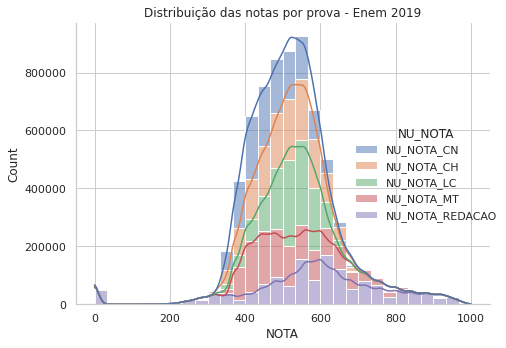

In [16]:
# Plotando a distibuição das notas
fig = plt.figure(figsize=(15,10))
sns.set_theme(style='whitegrid')
sns.displot(x='NOTA', data=disp_notas, hue='NU_NOTA', multiple='stack', bins=30, kde=True);
plt.title('Distribuição das notas por prova - Enem 2019')
plt.tight_layout()


In [17]:
print('Análise de distribuição das notas - 2019')
sk_kurt(enem19[notas_totais])

Análise de distribuição das notas - 2019
Skewness - NU_NOTA_CN: 0.33762927355361666 - Assimetria: Positiva
Kurtosis - NU_NOTA_CN: -0.3782117353925454
Skewness - NU_NOTA_CH: -0.28817150974479677 - Assimetria: Negativa
Kurtosis - NU_NOTA_CH: 1.0050736714479003
Skewness - NU_NOTA_LC: -0.7379565305781999 - Assimetria: Negativa
Kurtosis - NU_NOTA_LC: 2.4145587517122484
Skewness - NU_NOTA_MT: 0.6742554806344722 - Assimetria: Positiva
Kurtosis - NU_NOTA_MT: -0.08110206913590678
Skewness - NU_NOTA_REDACAO: -0.7535753210497631 - Assimetria: Negativa
Kurtosis - NU_NOTA_REDACAO: 1.3943692119969269


In [18]:
cols_names['Q001']

'Até que série seu pai estudou?'

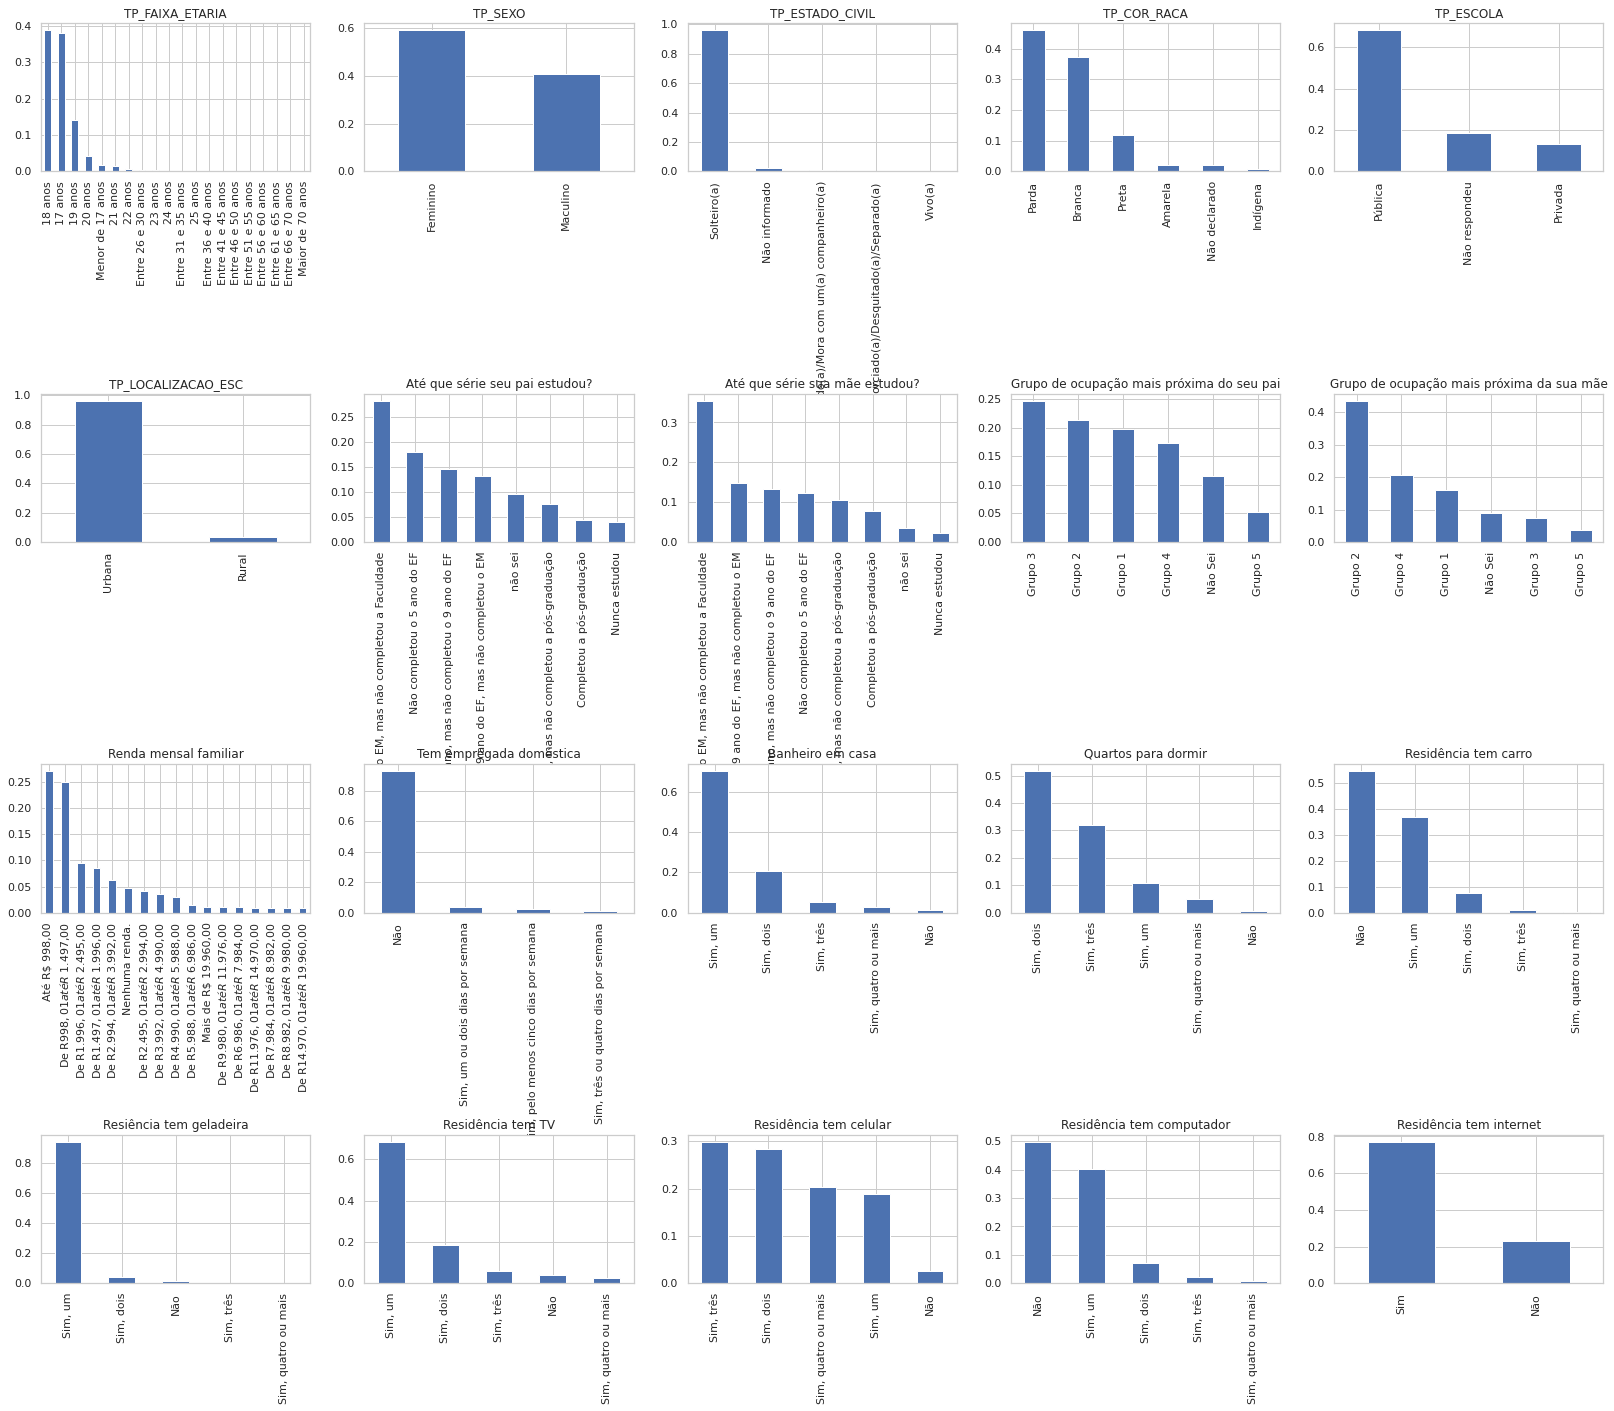

In [19]:
plt.figure(figsize=(28,30))
plt.subplots_adjust(hspace=1.5)
for i in enumerate(categorical_labels):
    plt.subplot(5, 5, i[0]+1)
    show_proportion(enem19, i[1])

#### Série Histórica

In [15]:
serie_abs = pd.read_parquet('../../Resultados/Agg/ENEM/anual/total_anos_enem.parquet').reset_index()
serie_norm = pd.read_parquet('../../Resultados/Agg/ENEM/anual/total_anos_norm_enem.parquet').reset_index()

In [16]:
serie_abs['NU_ANO'] = serie_abs['NU_ANO'].astype(int)
serie_norm['NU_ANO'] = serie_norm['NU_ANO'].astype(int)

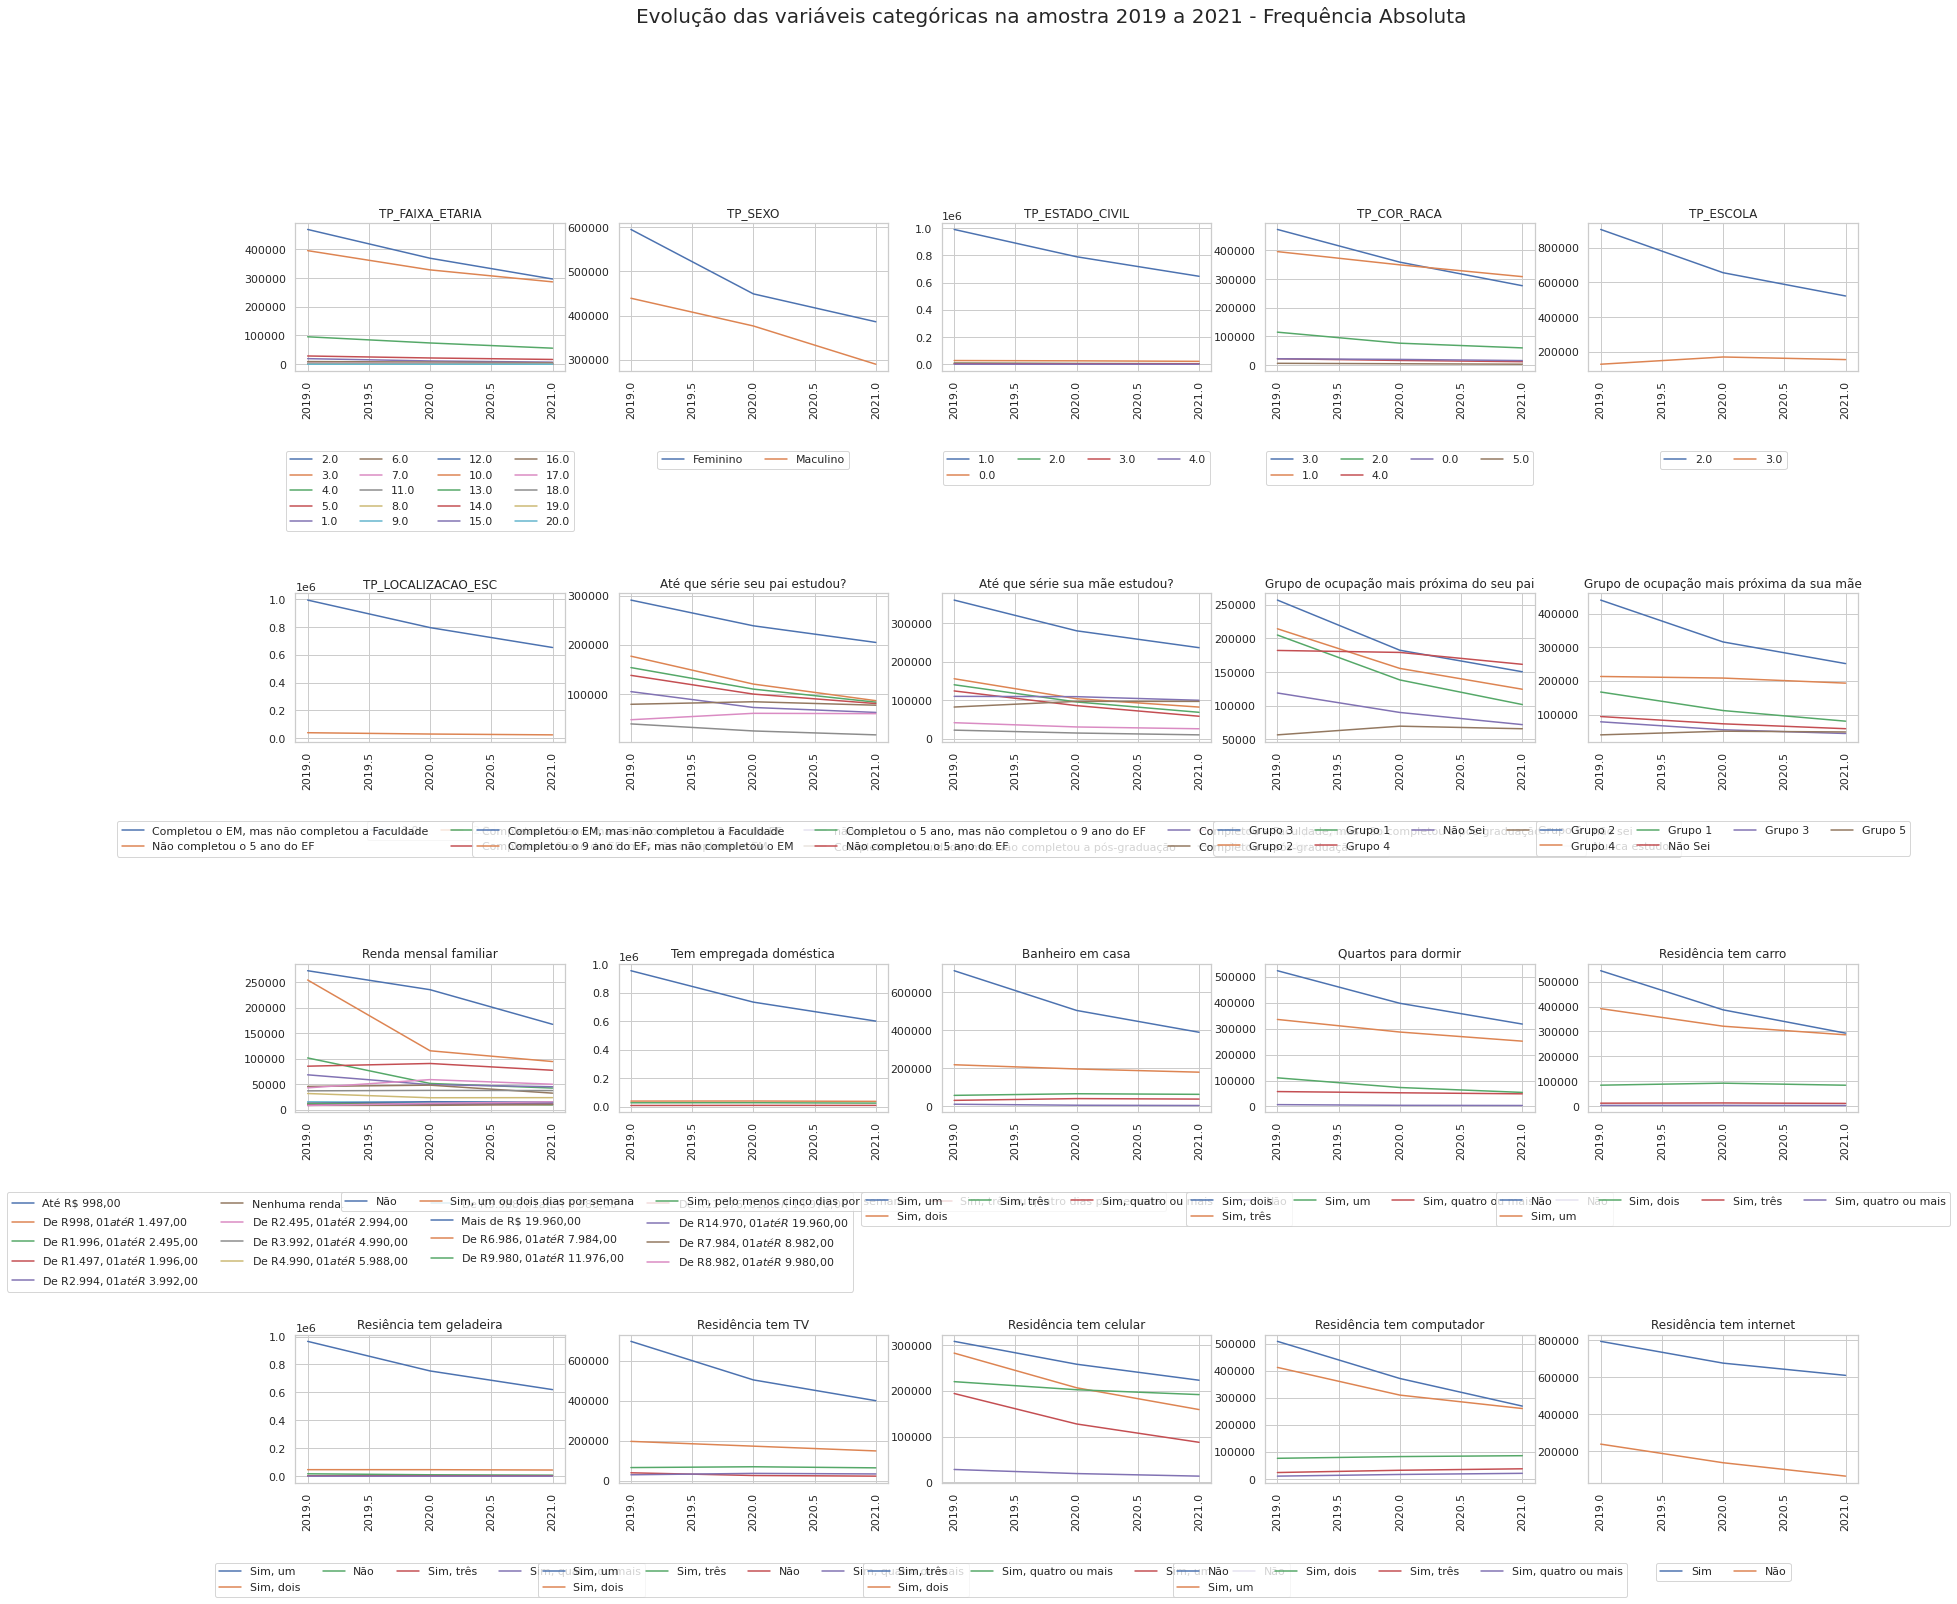

In [22]:
plt.figure(figsize=(28,30))
plt.subplots_adjust(hspace=1.5)
for i in enumerate(categorical_labels):
    plt.subplot(5, 5, i[0]+1)
    show_evolution(serie_abs, i[1])

plt.suptitle('Evolução das variáveis categóricas na amostra 2019 a 2021 - Frequência Absoluta', fontsize=20)
plt.show()

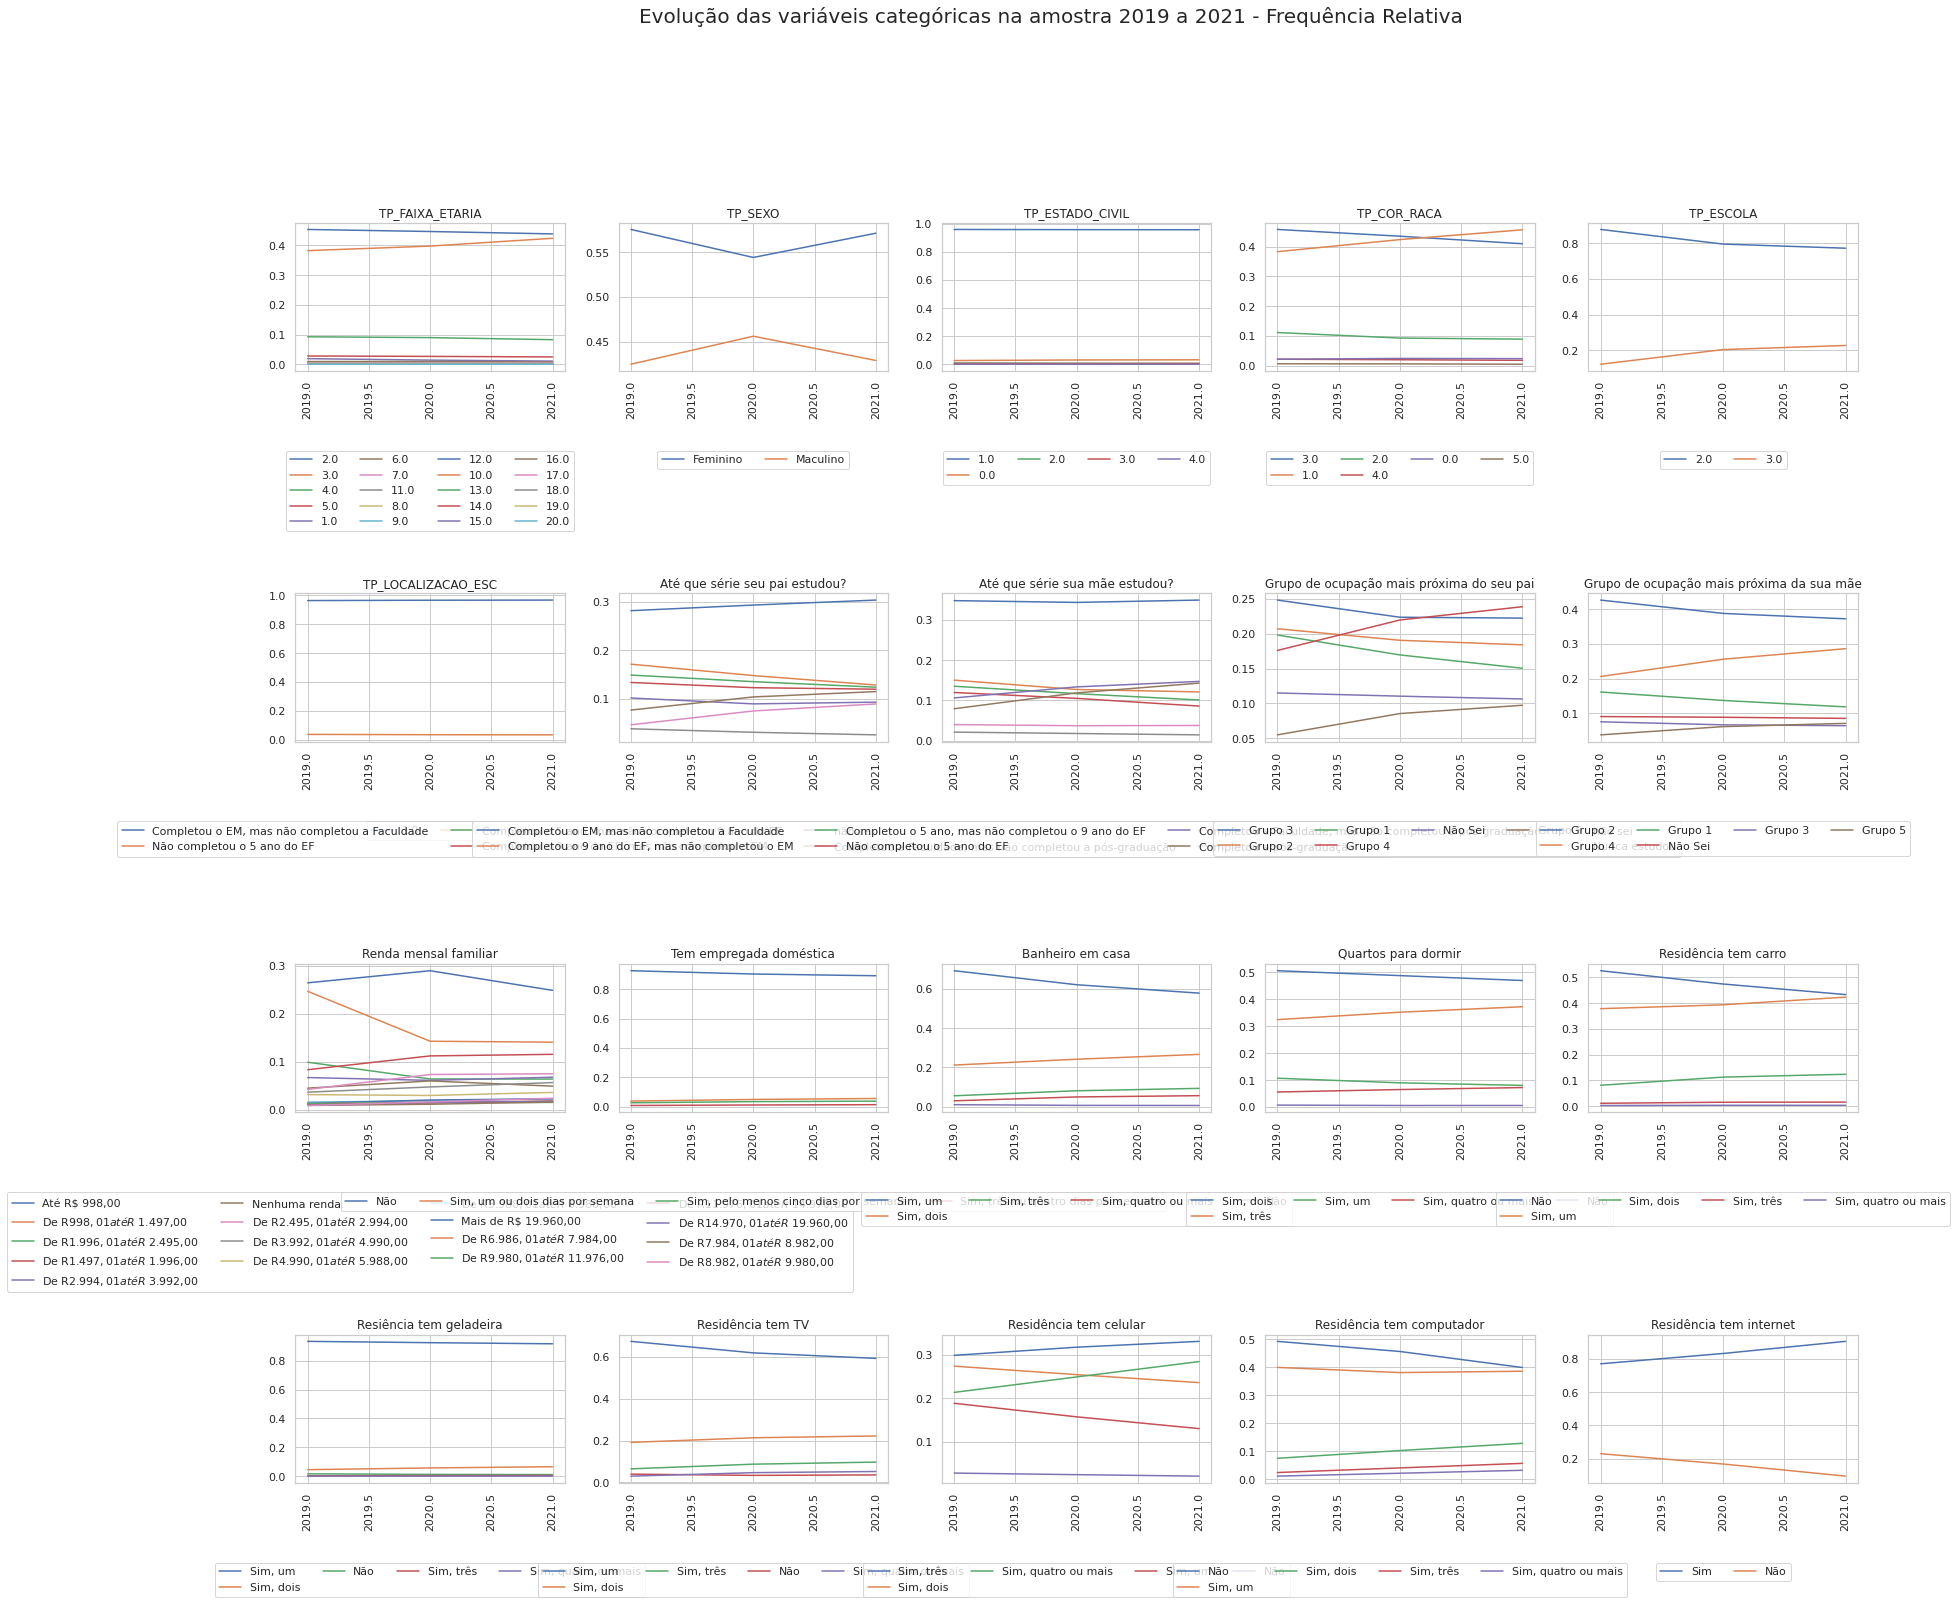

In [23]:
plt.figure(figsize=(28,30))
plt.subplots_adjust(hspace=1.5)
for i in enumerate(categorical_labels):
    plt.subplot(5, 5, i[0]+1)
    show_evolution(serie_norm, i[1])

plt.suptitle('Evolução das variáveis categóricas na amostra 2019 a 2021 - Frequência Relativa', fontsize=20)
plt.show()

- Houve um aumento na proporção dentre a amostra de inscritos para presença de internet em casa, de computador, e na quantidade de celulares. 
- É fundamental analisar como se distribui esse aumento

In [24]:
categorical_labels.keys()

dict_keys(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC', 'Q001', 'Q002', 'Q003', 'Q004', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q012', 'Q019', 'Q022', 'Q024', 'Q025'])

In [75]:
mascara_interesse = ['TP_COR_RACA', 'Q006','Q025','Q024','Q022']

In [100]:
evolucao_computador = cross_evolution(serie_abs, serie_norm, 'Q024')
evolucao_raca = cross_evolution(serie_abs, serie_norm, 'TP_COR_RACA')
evolucao_renda = cross_evolution(serie_abs, serie_norm, 'Q006')
evolucao_internet = cross_evolution(serie_abs, serie_norm, 'Q025')
evolucao_localizacao = cross_evolution(serie_abs, serie_norm, 'TP_LOCALIZACAO_ESC')
evolucao_dependencia = cross_evolution(serie_abs, serie_norm, 'TP_ESCOLA')
evolucao_celular = cross_evolution(serie_abs, serie_norm, 'Q022')


In [101]:
evolucao_raca.TP_COR_RACA = evolucao_raca.TP_COR_RACA.apply(lambda x: int(float(x))).replace(categorical_labels['TP_COR_RACA'])
evolucao_raca.NU_ANO = evolucao_raca.NU_ANO.astype(int).astype(str)
evolucao_computador.Q024 = evolucao_computador.Q024.replace(categorical_labels['Q024'])
evolucao_computador.NU_ANO = evolucao_computador.NU_ANO.astype(int).astype(str)
#evolucao_renda.Q006 = evolucao_renda.Q006.replace(categorical_labels['Q006'])
evolucao_renda.NU_ANO = evolucao_renda.NU_ANO.astype(int).astype(str)
evolucao_internet.Q025 = evolucao_internet.Q025.replace(categorical_labels['Q025'])
evolucao_internet.NU_ANO = evolucao_internet.NU_ANO.astype(int).astype(str)
evolucao_localizacao.TP_LOCALIZACAO_ESC = evolucao_localizacao.TP_LOCALIZACAO_ESC.apply(lambda x: int(float(x))).replace(categorical_labels['TP_LOCALIZACAO_ESC'])
evolucao_localizacao.NU_ANO = evolucao_localizacao.NU_ANO.astype(int).astype(str)
evolucao_dependencia.TP_ESCOLA = evolucao_dependencia.TP_ESCOLA.apply(lambda x: int(float(x))).replace(categorical_labels['TP_ESCOLA'])
evolucao_dependencia.NU_ANO = evolucao_dependencia.NU_ANO.astype(int).astype(str)
evolucao_celular.Q022 = evolucao_celular.Q022.replace(categorical_labels['Q022'])
evolucao_celular.NU_ANO = evolucao_celular.NU_ANO.astype(int).astype(str)

In [110]:
compare(evolucao_computador, 'Sim, quatro ou mais')

Variação em pontos perceituais para o filtro: Sim, quatro ou mais
Redução de -2.0888460436556207 p.p.


,NU_ANO,Q024,QTD_abs,QTD_norm
12,2019,"Sim, quatro ou mais",10758,0.010407
14,2021,"Sim, quatro ou mais",21157,0.031295


/tmp/ipykernel_37634/2519932025.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(evolucao_raca.NU_ANO)
/tmp/ipykernel_37634/2519932025.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(evolucao_renda.NU_ANO)
/tmp/ipykernel_37634/2519932025.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(evolucao_internet.NU_ANO)
/tmp/ipykernel_37634/2519932025.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(evolucao_localizacao.NU_ANO)
/tmp/ipykernel_37634/2519932025.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[5].set_xticklabels(evolucao_dependencia.NU_ANO)


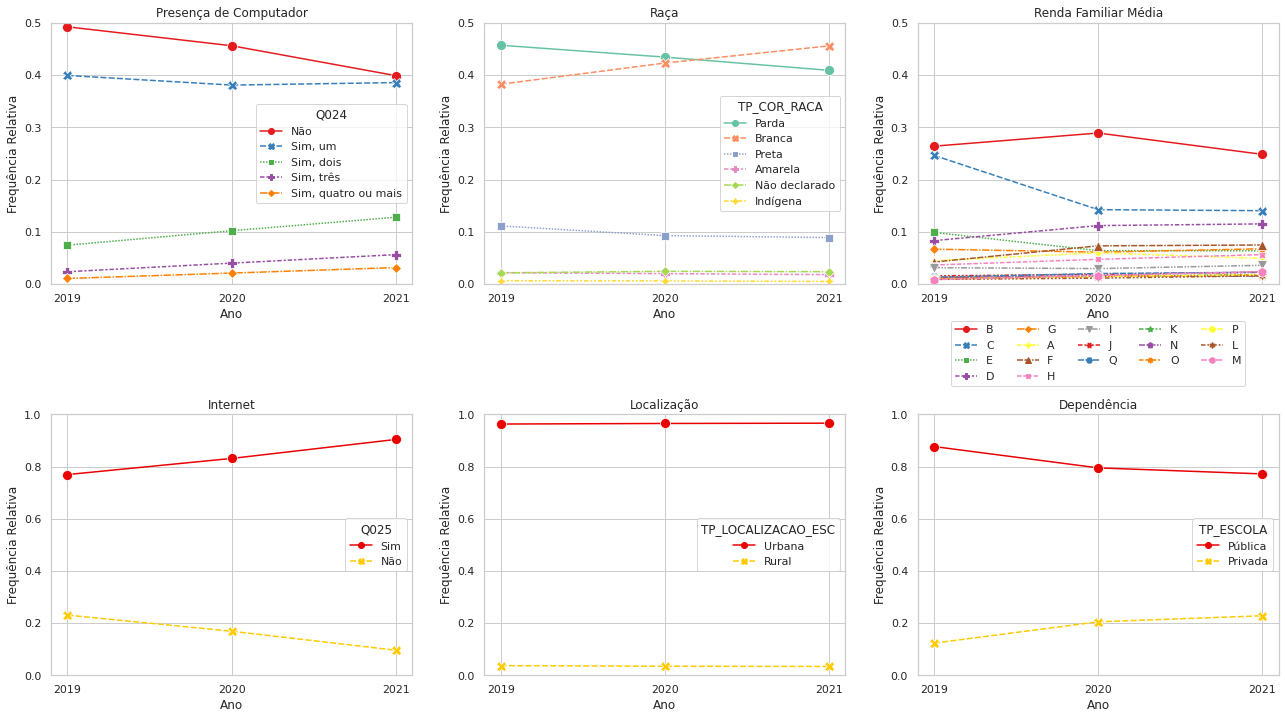

In [90]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(2,3, figsize=(22,12))
plt.subplots_adjust(hspace=.5)
ax = ax.flatten()
ax[0] = sns.lineplot(x='NU_ANO', y='QTD_norm', data=evolucao_computador, hue='Q024', ax=ax[0], palette='Set1', style='Q024', markers=True, markersize=10)
ax[0].set_title('Presença de Computador')
ax[0].set_ylim(0,0.5)
ax[0].set_xlabel('Ano')
ax[0].set_ylabel('Frequência Relativa')
#ax[0].set_xticklabels(evolucao_computador.NU_ANO.sort_values())

ax[1] = sns.lineplot(x='NU_ANO', y='QTD_norm', data=evolucao_raca, hue='TP_COR_RACA', ax=ax[1], palette='Set2', style='TP_COR_RACA', markers=True, markersize=10)
ax[1].set_title('Raça')
ax[1].set_ylim(0,0.5)
ax[1].set_xlabel('Ano')
ax[1].set_ylabel('Frequência Relativa')
ax[1].set_xticklabels(evolucao_raca.NU_ANO)

ax[2] = sns.lineplot(x='NU_ANO', y='QTD_norm', data=evolucao_renda, hue='Q006', ax=ax[2], palette='Set1', style='Q006', markers=True, markersize=10)
ax[2].set_title('Renda Familiar Média')
ax[2].set_ylim(0,0.5)
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=False, ncol=5) #lower left)
ax[2].set_xlabel('Ano')
ax[2].set_ylabel('Frequência Relativa')
ax[2].set_xticklabels(evolucao_renda.NU_ANO)

ax[3] = sns.lineplot(x='NU_ANO', y='QTD_norm', data=evolucao_internet, hue='Q025', ax=ax[3], palette='hot', style='Q025', markers=True, markersize=10)
ax[3].set_title('Internet')
ax[3].set_ylim(0,1)
ax[3].set_xlabel('Ano')
ax[3].set_ylabel('Frequência Relativa')
ax[3].set_xticklabels(evolucao_internet.NU_ANO)

ax[4] = sns.lineplot(x='NU_ANO', y='QTD_norm', data=evolucao_localizacao, hue='TP_LOCALIZACAO_ESC', ax=ax[4], palette='hot', style='TP_LOCALIZACAO_ESC', markers=True, markersize=10)
ax[4].set_title('Localização')
ax[4].set_ylim(0,1)
ax[4].set_xlabel('Ano')
ax[4].set_ylabel('Frequência Relativa')
ax[4].set_xticklabels(evolucao_localizacao.NU_ANO)

ax[5] = sns.lineplot(x='NU_ANO', y='QTD_norm', data=evolucao_dependencia, hue='TP_ESCOLA', ax=ax[5], palette='hot', style='TP_ESCOLA', markers=True, markersize=10)
ax[5].set_title('Dependência')
ax[5].set_ylim(0,1)
ax[5].set_xlabel('Ano')
ax[5].set_ylabel('Frequência Relativa')
ax[5].set_xticklabels(evolucao_dependencia.NU_ANO)
plt.show()

- Houve aumento na presença de grupos de renda familiar superiores.
- Redução na proporção de inscritos em escolas públicas.
- Redução na proporção de inscritos pardos e aumento na proporção de inscritos brancos.

Parte do aumento na conectividade é explicado pela adoção do formato EAD durante o período, porém a mudança nas características da amostra dificultam esse teste

Matching: analisar efeito da conectividade e tecnologia nos grupamentos compatíveis. Estudantes de escolas públicas de baixa renda, com variáveis socioeconômicas semelhantes, proporção de conexão escolar semelhante no município, etc;

Com o período da pandemia, diferenças nos scores obtidos entre grupo de controle e tratamento podem ser causadas por fatores diversos não observados (eg: morte de familiar, fatores psicológicos como ansiedade, incerteza, depressão, problemas familiares.)

## Estatística Multivariada
- Notas x idade
- Notas x renda familiar
- Notas x internet na escola
- Notas x internet em casa
- Notas x profissão do pai
- Notas x profissão da mãe
- Notas x outras características da escola *

Tipos de análise:


y:..................x:....................stat:

numeric......numeric........pearson correlation

numeric......categorical....one-way ANOVA

categorical..numeric........Pearson chi-squared test

In [29]:
enem19.head()

,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q012,Q019,Q022,Q024,Q025
8,2019,5,F,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,C,C,F,6,C,A,B,C,A,B,B,B,A,A
9,2019,2,M,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,543.9,548.1,502.5,480.7,1.0,120.0,40.0,120.0,120.0,0.0,400.0,E,E,B,B,5,F,A,B,C,B,B,B,C,B,B
11,2019,4,M,1,4,1,NaN,NaN,NaN,NaN,NaN,NaN,518.2,351.7,417.6,459.0,1.0,120.0,120.0,120.0,120.0,20.0,500.0,B,C,C,A,4,C,A,C,D,A,B,B,D,B,B
13,2019,6,F,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,458.9,441.6,413.0,399.0,1.0,80.0,40.0,40.0,80.0,0.0,240.0,E,E,E,B,4,D,A,B,C,A,B,B,C,A,A
15,2019,4,M,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,B,C,F,4,B,A,B,C,A,B,B,C,A,B


### Correlação entre variáveis categóricas

Assumptions:
- Normal distribution of the numeric variable for each group of the categorcial variable
- Equal variance of the numeric variable for each group of the categorcial variable
  - If not, use Welch's t-test
- Sample data is independent of the categorical variable

In [30]:
notas = [col for col in enem19.columns if 'NU_NOTA_' in col and 'COMP' not in col]
notas_por_sexo = notas.copy()
notas_por_sexo.append('TP_SEXO')

In [31]:
dist_notas = enem19[notas_por_sexo]
dist_notas = dist_notas.melt(id_vars=['TP_SEXO'], value_vars=notas, var_name='Nota')
dist_notas.Nota.replace({'NU_NOTA_CH':'Ciênc. Humanas','NU_NOTA_CN': 'Ciênc. Natureza', 'NU_NOTA_LC': 'Linguagens', 'NU_NOTA_MT': 'Matemática', 'NU_NOTA_REDACAO': 'Redação'}, inplace=True)
dist_notas.TP_SEXO.replace({'F': 'Feminino', 'M': 'Masculino'}, inplace=True)
dist_notas.rename(columns={'TP_SEXO':'Sexo'}, inplace=True)

In [32]:
dist_notas.describe()

,value
count,6.859953e+06
mean,5.221333e+02
std,1.194248e+02
min,0.000000e+00
25%,4.474000e+02
50%,5.178000e+02
75%,5.800000e+02
max,1.000000e+03


In [33]:
dist_notas.Sexo.value_counts(normalize=True)

Feminino     0.592337
Masculino    0.407663
Name: Sexo, dtype: float64

In [34]:
mulheres = enem19[notas_por_sexo].query('TP_SEXO == "F"').drop(columns=['TP_SEXO'])
homens = enem19[notas_por_sexo].query('TP_SEXO == "M"').drop(columns=['TP_SEXO'])

In [35]:
print('Análise de distribuição das notas - Mulheres')
sk_kurt(mulheres)
print('\n')
print('Análise de distribuição das notas - Homens')
sk_kurt(homens)

Análise de distribuição das notas - Mulheres
Skewness - NU_NOTA_CN: 0.3906627173033237 - Assimetria: Positiva
Kurtosis - NU_NOTA_CN: -0.3723937148037981
Skewness - NU_NOTA_CH: -0.27399885023438775 - Assimetria: Negativa
Kurtosis - NU_NOTA_CH: 1.0825704714315711
Skewness - NU_NOTA_LC: -0.7244529006481184 - Assimetria: Negativa
Kurtosis - NU_NOTA_LC: 2.706946916191914
Skewness - NU_NOTA_MT: 0.778178528110207 - Assimetria: Positiva
Kurtosis - NU_NOTA_MT: 0.1699583938031375
Skewness - NU_NOTA_REDACAO: -0.7387747920582434 - Assimetria: Negativa
Kurtosis - NU_NOTA_REDACAO: 1.443638882253425


Análise de distribuição das notas - Homens
Skewness - NU_NOTA_CN: 0.23439710517652146 - Assimetria: Positiva
Kurtosis - NU_NOTA_CN: -0.39122646146216855
Skewness - NU_NOTA_CH: -0.3358162553512876 - Assimetria: Negativa
Kurtosis - NU_NOTA_CH: 0.9295717233010703
Skewness - NU_NOTA_LC: -0.7472288399780032 - Assimetria: Negativa
Kurtosis - NU_NOTA_LC: 2.0321184015860756
Skewness - NU_NOTA_MT: 0.471811200305

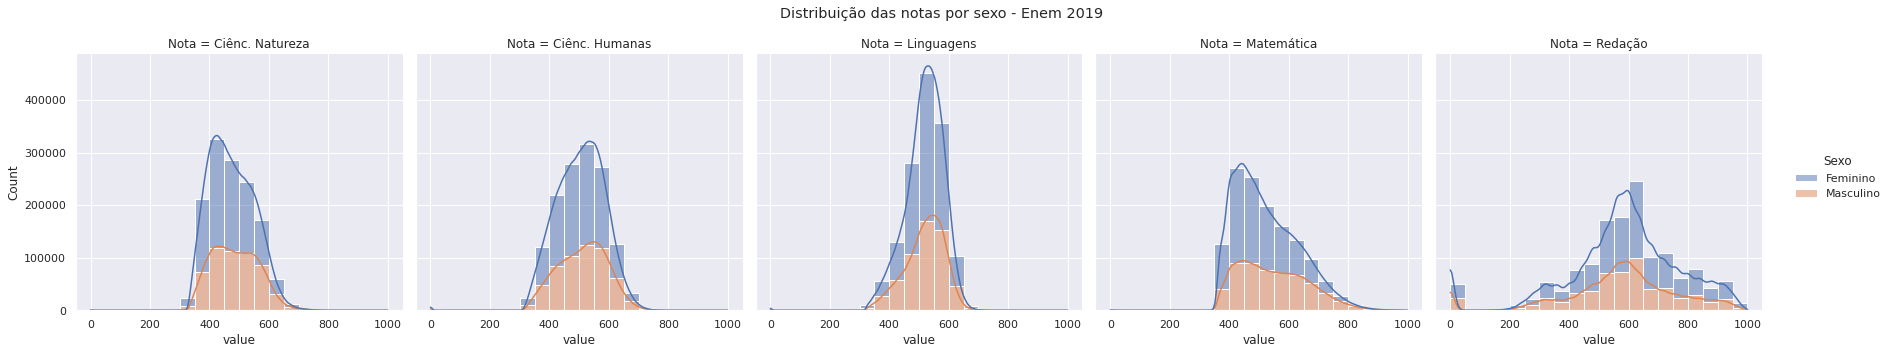

In [36]:
sns.set_theme(style='darkgrid')
ax = sns.displot(
    dist_notas, 
    x='value', 
    hue='Sexo', 
    col='Nota', 
    multiple="stack", 
    kde=True,
    bins=20,);
ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Distribuição das notas por sexo - Enem 2019')
#ax.set_xlabel('Nota')
#ax.set_ylabel('Frequência')
plt.show()

<Figure size 864x432 with 0 Axes>

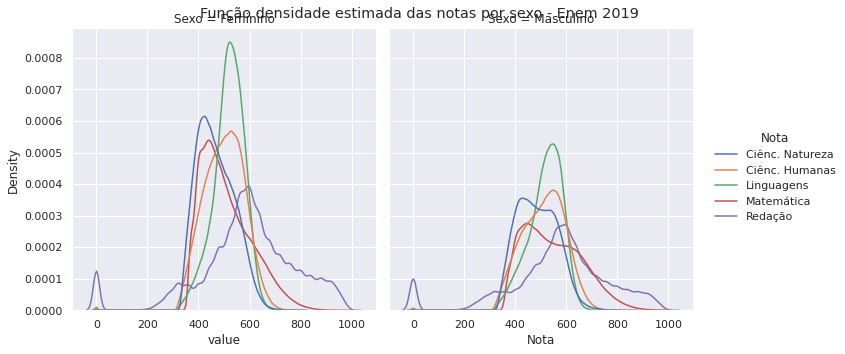

In [40]:
fig = plt.figure(figsize=(12,6))
sns.displot(dist_notas, x='value', hue='Nota', col='Sexo', kind='kde')
plt.suptitle('Função densidade estimada das notas por sexo - Enem 2019')
plt.xlabel('Nota')
plt.ylabel('Densidade')

plt.show()

### Correlação entre variáveis numéricas

In [38]:
corr_df = pd.DataFrame(columns=['r', 'p_value'])
for col in enem19:
    if pd.api.types.is_numeric_dtype(enem19[col]):
        r, p = stats.spearmanr(enem19[col], enem19['NU_NOTA_MT'])
        corr_df.loc[col] = [round(r, 3), round(p, 3)]

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


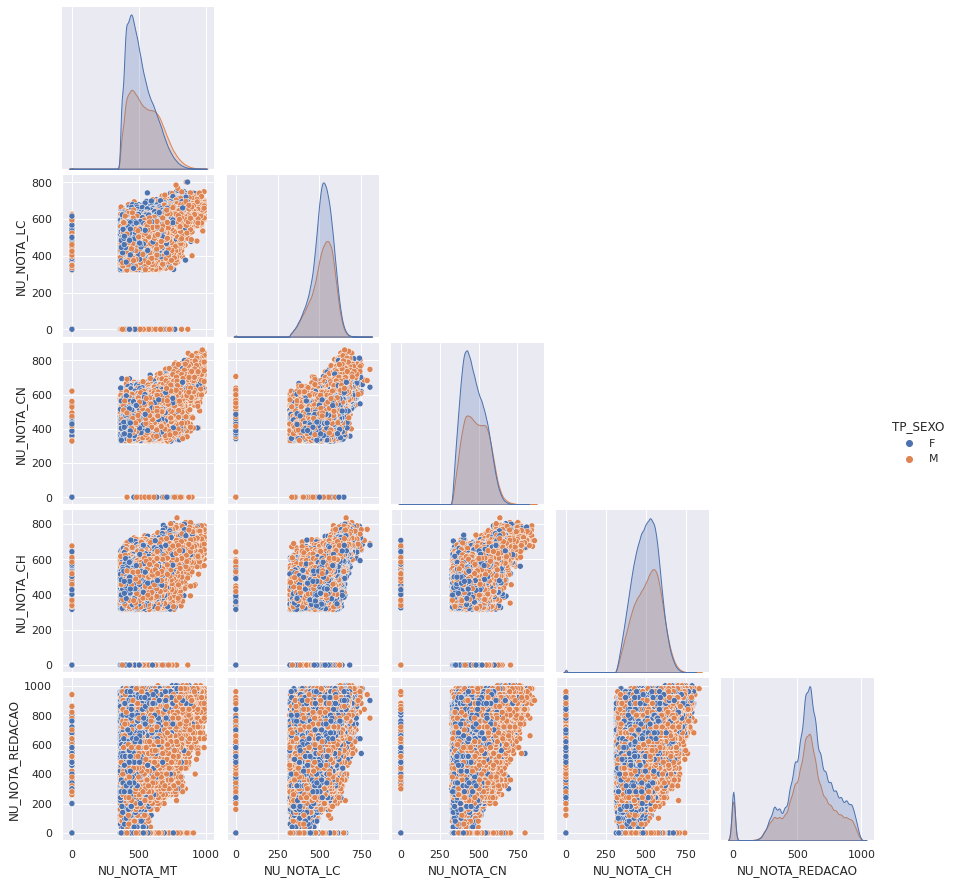

In [39]:
sns.pairplot(enem19, vars=['NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_REDACAO'], corner=True, hue='TP_SEXO');

# Análise Agregada